In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy import stats
from statistics import mean
from statistics import stdev


def load_data(path, columns):
    '''With this function, Excel files can be loaded into Python. The path to the file and the desired columns from the
    Excel file must be specified. A dataframe is returned.'''
    df = pd.read_excel(path, usecols=columns)
    return df


def drop_data(threshold_column, threshold_row, df):
    '''With this function, data with less than threshold % of non-NaN values will be dropped from the dataset.
    The thresholds for dropping columns and rows must be specified as a value between 0 and 1 and the input must be a dataframe.
    The dataframe with removed rows and columns is returned.'''
    df_col = df.dropna(axis=1, thresh=threshold_column*list(df.shape)[0])
    df_drop = df_col.dropna(axis=0, thresh=threshold_row*list(df_col.shape)[1])
    return df_drop


def baseline(df_0_baseline, df_1_baseline):
    '''With this function, the age and gender of two dataframes will be statistically compared.
    Two separate dataframes of two groups including columns age and gender must be given as input.
    A dataframe with means and standard deviations of the two groups and a p-value indicating the difference
    between the two groups will be returned.'''
    # First calculate the means and stds of age in the two groups, rounded to two decimals
    mean_age_0 = np.round(df_0_baseline['Leeftijd'].mean(), decimals=2)
    std_age_0 = np.round(df_0_baseline['Leeftijd'].std(), decimals=2)
    mean_age_1 = np.round(df_1_baseline['Leeftijd'].mean(), decimals=2)
    std_age_1 = np.round(df_1_baseline['Leeftijd'].std(), decimals=2)
    # Next, find the percentage of females per group
    f_gender_0 = (df_0_baseline['Geslacht'].sum())/len(df_0_baseline)
    f_gender_1 = (df_1_baseline['Geslacht'].sum())/len(df_1_baseline)
    # Calculate the difference in gender with a Chi-square and the difference in age with a Student's t-test
    _, p_gender, _, _ = chi2_contingency(pd.crosstab(df_0_baseline['Geslacht'], df_1_baseline['Geslacht']))
    _, p_age = stats.ttest_ind(df_0_baseline['Leeftijd'], df_1_baseline['Leeftijd'])
    # Combine the calculated values into a dictionary, that is converted to a dataframe for visualisation.
    dict_table = {'Amount of patients': [f'N={len(df_1_baseline)}', f'N={len(df_0_baseline)}', ' '],
                  'Age': [f'{mean_age_1} ± {std_age_1}', f'{mean_age_0} ± {std_age_0}', np.round(p_age, decimals=2)],
                  'Gender': [f'{np.round(f_gender_1*100, decimals=0)}% females (N={np.round(f_gender_1*len(df_1_baseline), decimals=0)})',
                             f'{np.round(f_gender_0*100, decimals=0)}% females (N={np.round(f_gender_0*len(df_0_baseline), decimals=0)})', np.round(p_gender, decimals=2)]}
    df_characteristics = pd.DataFrame.from_dict(dict_table, orient='index', columns=['ID group', 'no ID group', 'P-value'])
    return df_characteristics


def impute_data(data_train, data_test, df_decimal):
    '''With this function, missing values are imputed with a 3-Nearest Neighbors imputer with a weight depending on distance.
    The imputer is fit on the train set and applied to the test set. The imputed values are rounded differently for every column.
    Two dataframes with train and test data must be given as input. The amount of decimals per feature must also be given as input in a separate dataframe.
    Two dataframes with train and test data with imputed (and rounded) values are returned.'''
    # Find the feature names in the data
    columns_data = list(data_train.columns)

    # Imputation of NaN's with KNN
    imputer = KNNImputer(n_neighbors=3, weights="distance")
    impute_train = imputer.fit_transform(data_train)
    impute_test = imputer.transform(data_test)

    # Create dataframes of train and test data with imputed values
    df_train = pd.DataFrame(impute_train, columns=columns_data)
    df_test = pd.DataFrame(impute_test, columns=columns_data)

    # Round the imputed values differently for every column
    for column in columns_data:   # Loop over the different features
        df_train.loc[:, column] = np.round(df_train[column], decimals=int(df_decimal[column].to_string(index=False)))   # Convert to string to remove the index of the dataframe. Convert to int because the amount of decimals is an integer.
        df_test.loc[:, column] = np.round(df_test[column], decimals=int(df_decimal[column].to_string(index=False)))
    return df_train, df_test


def scale_data(data_train, data_test, continuous_keys, ordinal_keys):
    '''With this function, data is scaled between 0 and 1. Scaling is done differently for different types of variables.
    Continuous data is scaled between 0 and 1 with a MinMaxScaler. Scaling ordinal keys with multiple classes is done with conditional probabilities.
    Dataframes of the train and test data and lists of keys of continuous features and ordinal features must be given as input.
    The function is fit on the train set and applied to the test set. Two dataframes of scaled train and test data are returned.'''

    # First scale the continuous features with a MinMaxScaler:
    scaler = preprocessing.MinMaxScaler()  # Define the scaler
    df_for_scaler_train = data_train[continuous_keys].copy()  # Create a copy dataframe with only the continuous keys of the train data
    df_for_scaler_test = data_test[continuous_keys].copy()   # Create a copy dataframe with only the continuous keys of the test data
    
    # Scale the continuous features of the train and test data
    scale_train = scaler.fit_transform(df_for_scaler_train)
    scale_test = scaler.transform(df_for_scaler_test)

    # Replace the columns of train and test data by the scaled values
    data_train.loc[:, (continuous_keys)] = scale_train
    data_test.loc[:, (continuous_keys)] = scale_test

    # Next, scale the ordinal features by replacing them with conditional probabilities:
    prob = []   # Create an empty list that will be filled by the calculated probabilities
    prob_train = data_train[ordinal_keys].copy()   # Create a copy dataframe with only the ordinal keys from the train data
    prob_test = data_test[ordinal_keys].copy()   # Create a copy dataframe with only the ordinal keys from the test data

    for ordinal in ordinal_keys:   # Loop over all the ordinal keys
        if int(prob_train[ordinal].max()) > 0:   # Only if the max of the ordinal column is larger than 0
            for i in range(1, int(prob_train[ordinal].max()+1)):   # Loop over range from 1 to the maximum value in the ordinal column
                prob_train['Ordinal value'] = np.where(prob_train[ordinal] > 0, 1, 0)   # Select only patients with >0 for this ordinal value
                prob_train[f"Amount = {i}"] = np.where(prob_train[ordinal] == i, 1, 0)   # Select only patients with i for this ordinal value
                prob_train['count'] = 1   # A help for developing a pivot table
                prob_df = prob_train[['Ordinal value', f"Amount = {i}", 'count']]   # Create a dataframe with only the columns necessary for creating a pivot table
                table = pd.pivot_table(prob_df, values='count', index=[f"Amount = {i}"], columns=['Ordinal value'], aggfunc=np.size, fill_value=0)   # Create a pivot table
                if table.size == 4:   # If the pivot table exists of 4 values, this means that i exists in the column
                    # Calculate the conditional probability with the following three rows
                    P_B = (table.values[0, 1]+table.values[1, 1])/(sum(sum(table.values)))
                    P_A_B = table.values[1, 1]/(sum(sum(table.values)))
                    prob.append(P_A_B / P_B)
                    prob_train[ordinal].replace({i: prob[-1]}, inplace=True)   # Replace i in the train column by the last added probability
                    prob_test[ordinal].replace({i: prob[-1]}, inplace=True)   # Replace i in the train column by the last added probability
                else:
                    continue

    prob_train_final = prob_train[prob_test.keys()]   # Remove the keys that were added for the pivot table
    # Replace the columns of train and test data by the scaled values
    data_train.loc[:, (ordinal_keys)] = prob_train_final[ordinal_keys]
    data_test.loc[:, (ordinal_keys)] = prob_test[ordinal_keys]
    return data_train, data_test


def feature_selection(train_data, train_label, index_train, ordinal_keys, binary_keys, continuous_keys, sign_features_dfs):
    '''With this function, feature selection is done with univariate statistical testing. Dataframes with train data, train labels and train indices
    must be given as input in order to merge the train data and labels. Also lists of keys of ordinal features, binary features and continuous features
    must be given as input. A dataframe with significant features must be given as input and will be appended every fold. This appended list is returned
    and can be used for reporting. Also, a list of only the significant features in this fold is returned. This can be used for the creation of models
    with only significant features. Binary data is tested with Chi-square, ordinal data with multiple classes with a Mann-Whitney U test and continuous
    data with a Student's t-test. The p-values are corrected with a Holm-Bonferroni correction.'''
    # Merge data with labels again for statistics
    merge_data_train = train_data.merge(train_label, on=index_train, how='inner')
    # Create to dataframes for the different populations
    df_num_0 = merge_data_train.loc[merge_data_train['Label'] == 0.0]
    df_num_1 = merge_data_train.loc[merge_data_train['Label'] == 1.0]
    # Create dataframe to fill with p-values
    df_p = pd.DataFrame({'Features': ordinal_keys+binary_keys+continuous_keys})

    # Chi-square for binary data
    for key in binary_keys:
        _, p, _, _ = chi2_contingency(pd.crosstab(merge_data_train['Label'], merge_data_train[key]))   # Perform the Chi square test
        df_p.loc[df_p['Features'] == key, 'P-value'] = p   # Fill dataframe with p-values
        # Calculate the mean and std for the two populations and fill in dataframe
        mean_ID = np.round(df_num_1[key].mean(), decimals=2)
        std_ID = np.round(df_num_1[key].std(), decimals=2)
        mean_no_ID = np.round(df_num_0[key].mean(), decimals=2)
        std_no_ID = np.round(df_num_0[key].std(), decimals=2)
        df_p.loc[df_p['Features'] == key, 'Mean ± std ID'] = f'{mean_ID} ± {std_ID}'
        df_p.loc[df_p['Features'] == key, 'Mean ± std no ID'] = f'{mean_no_ID} ± {std_no_ID}'

    # Mann Whitney U test for multiple class ordinal data
    for key in ordinal_keys:
        _, p = mannwhitneyu(df_num_0[key], df_num_1[key])   # Perform the Mann Whitney U test
        df_p.loc[df_p['Features'] == key, 'P-value'] = p   # Fill dataframe with p-values
        # Calculate the mean and std for the two populations and fill in dataframe
        mean_ID = np.round(df_num_1[key].mean(), decimals=2)
        std_ID = np.round(df_num_1[key].std(), decimals=2)
        mean_no_ID = np.round(df_num_0[key].mean(), decimals=2)
        std_no_ID = np.round(df_num_0[key].std(), decimals=2)
        df_p.loc[df_p['Features'] == key, 'Mean ± std ID'] = f'{mean_ID} ± {std_ID}'
        df_p.loc[df_p['Features'] == key, 'Mean ± std no ID'] = f'{mean_no_ID} ± {std_no_ID}'

    # Student's t-test for continuous data
    for key in continuous_keys:
        _, p = stats.ttest_ind(df_num_0[key], df_num_1[key])   # Perform the Student's t-test
        df_p.loc[df_p['Features'] == key, 'P-value'] = p    # Fill dataframe with p-values
        # Calculate the mean and std for the two populations and fill in dataframe
        mean_ID = np.round(df_num_1[key].mean(), decimals=2)
        std_ID = np.round(df_num_1[key].std(), decimals=2)
        mean_no_ID = np.round(df_num_0[key].mean(), decimals=2)
        std_no_ID = np.round(df_num_0[key].std(), decimals=2)
        df_p.loc[df_p['Features'] == key, 'Mean ± std ID'] = f'{mean_ID} ± {std_ID}'
        df_p.loc[df_p['Features'] == key, 'Mean ± std no ID'] = f'{mean_no_ID} ± {std_no_ID}'

    # Find significant p-values by Holm-Bonferroni:
    df_p_sorted = df_p.sort_values(by=['P-value'])    # Sort the values by p-values
    df_p_sorted['Rank'] = range(1, len(df_p_sorted)+1)    # Rank the features
    df_p_sorted['Significance level'] = 0.05/(len(df_p_sorted)+1-df_p_sorted['Rank'])    # Calculate the significance level per feature
    df_p_sorted['Significant'] = np.where(df_p_sorted['P-value'] < df_p_sorted['Significance level'], 'Yes', 'No')    # Find which features are significant

    # Create dataframe with significant features only and create table for visualisation
    df_p_sign = df_p_sorted.loc[df_p_sorted['Significant'] == 'Yes']
    df_p_for_table = df_p_sign.drop(['Rank'], axis=1)

    # Append the dataframe with significant features to a list for every fold. In this list, the dataframes for the 10 folds are stored.
    sign_features_dfs.append(df_p_for_table)

    # Create list of significant features that can be used for model creation
    sign = df_p_sign['Features'].tolist()
    return sign, sign_features_dfs


def pipeline_model(train_data, train_label, test_data, test_label, clf, tprs, aucs, spec, sens, accuracy, axis):
    '''In this function, a machine learning model is created and tested. Dataframes of the train data, train labels, test data and test labels
    must be given as input. Also, the classifier must be given as input. Scoring metrics true positives, area under curve, specificity, sensitivity
    and accuracy must be given as input, these scores are appended every fold and are returned. The axis must also be given in order to plot the ROC curves
    for the different folds in the right figure.'''
    # Fit and test the classifier
    clf.fit(train_data, train_label)
    predicted = clf.predict(test_data)

    # plot ROC-curve per fold
    mean_fpr = np.linspace(0, 1, 100)    # Help for plotting the false positive rate
    viz = metrics.plot_roc_curve(clf, test_data, test_label, name='ROC fold {}'.format(i), alpha=0.3, lw=1, ax=axis)    # Plot the ROC-curve for this fold on the specified axis.
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)    # Interpolate the true positive rate
    interp_tpr[0] = 0.0    # Set the first value of the interpolated true positive rate to 0.0
    tprs.append(interp_tpr)   # Append the interpolated true positive rate to the list
    aucs.append(viz.roc_auc)    # Append the area under the curve to the list

    # Calculate the scoring metrics
    tn, fp, fn, tp = confusion_matrix(test_label, predicted).ravel()   # Find the true negatives, false positives, false negatives and true positives from the confusion matrix
    spec.append(tn/(tn+fp))    # Append the specificity to the list
    sens.append(tp/(tp+fn))    # Append the sensitivity to the list
    accuracy.append(metrics.accuracy_score(test_label, predicted))    # Append the accuracy to the list

    return tprs, aucs, spec, sens, accuracy


def mean_ROC_curves(tprs_all, aucs_all, axis_all):
    '''With this function, the mean ROC-curves of the models over a 10-cross-validation are plot.
    The true positive rates, areas under the curve and axes where the mean ROC-curve must be plot
    are given as input for different models. The figures are filled with the mean and std ROC-curve and
    can be visualized with plt.show()'''
    for i, (tprs, aucs, axis) in enumerate(zip(tprs_all, aucs_all, axis_all[:3])):   # Loop over the tprs, aucs and first three axes for the figures of the three different models.
        # Calculate means and standard deviations of true positive rate, false positive rate and area under curve
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_fpr = np.linspace(0, 1, 100)
        mean_auc = metrics.auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        std_tpr = np.std(tprs, axis=0)
        axis.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)   # Plot the mean ROC-curve for the corresponding model
        axis_all[3].plot(mean_fpr, mean_tpr, label=fr'Mean ROC model {(i+1)} (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)    # Plot the mean ROC-curve for the corresponding model in another figure
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)    # Set the upper value of the true positive rates
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    # Set the upper value of the true positive rates
        axis.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')    # Plot the standard deviations of the ROC-curves
        axis.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=f'ROC-curves model {i+1}')    # Set axes and title
        axis.legend(loc="lower right")    # Set legend
        axis_all[3].fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=.2, label=r'$\pm$ 1 std. dev.')    # Plot the standard deviations of the ROC-curves in another figure
        axis_all[3].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title='Mean ROC-curve for the three models')    # Set axes and title
        axis_all[3].legend(loc="lower right")    # Set legend
    return


Number of columns before dropped columns: 1498
Number of columns after dropped columns: 128


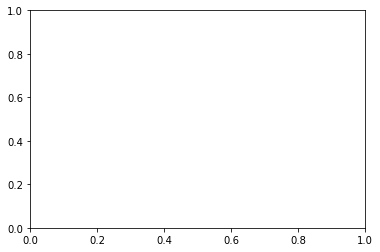

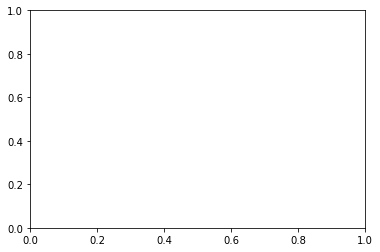

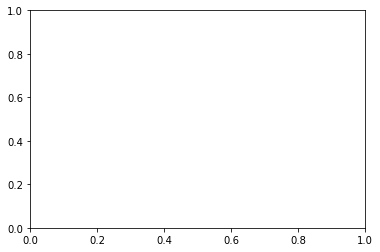

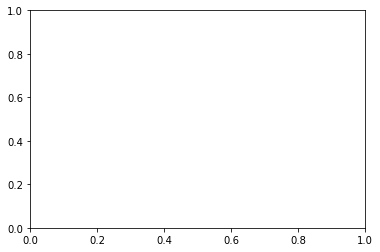

In [2]:
# Load and merge data. Define paths and columns wanted from Excel files
path_data = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v6_dataset.xlsx'
columns_data = "A:BBB"
path_labels = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/IDA_aangevuld.xls'
columns_labels = "A:B"
path_phecodes = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/phecodes_filled_binary.xlsx'
columns_phecodes = "A:R"
path_specialisms = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/Letters_DBC_combined.xlsx'
columns_specialisms = "A:BW"
path_decimals = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/afronden_features.xlsx'
columns_decimals = 'A:EO'
path_baseline = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/baseline.xlsx'
columns_baseline = 'A:C'

# df data contains most of the features needed to build the model
df_data = load_data(path_data, columns_data)
# df labels contains the label ID/ no ID
df_labels = load_data(path_labels, columns_labels)
# df phecodes contains the data about the diagnoses a patient has, categorized into groups
df_phecodes = load_data(path_phecodes, columns_phecodes)
# df spec contains the data about what specialisms a patient visited
df_spec = load_data(path_specialisms, columns_specialisms)
# df decimal contains the amount of decimals for rounding the different features
df_decimal = load_data(path_decimals, columns_decimals)
# df baseline contains baseline characteristics age and gender
df_baseline = load_data(path_baseline, columns_baseline)

# Merge dataframes
df_hix_spec = df_data.merge(df_spec, on='Pt_no', how='outer')
df_hix_phecodes = df_hix_spec.merge(df_phecodes, on='Pt_no', how='outer')
# In df hix, all features are merged inside one dataframe. The specialisms, phecodes and labels are added
df_hix = df_hix_phecodes.merge(df_labels, on='Pt_no', how='inner')
print('Number of columns before dropped columns: ' + str(len(df_hix.columns)))

# Defining thresholds for dropping rows and columns with missing data (threshold of amount of non-NA values required)
threshold_column = 0.7
threshold_row = 0.6

# Drop columns and rows with too many NaN's
df_dropped = drop_data(threshold_column, threshold_row, df_hix)

print('Number of columns after dropped columns: ' + str(len(df_dropped.columns)))

# Balance set by picking random samples from no ID group # hierrr
df_ID_1 = df_dropped.loc[df_dropped['Label'] == 1.0]
df_ID_0_all = df_dropped.loc[df_dropped['Label'] == 0.0]
# random_state makes sure that the same sample is picked every time #HIERHIERHIERHEI
df_ID_0 = df_ID_0_all.sample(n=df_ID_1.shape[0], random_state=2)
# df drop contains the dataframe with the subset of no ID patients and all ID patients
df_drop = pd.concat([df_ID_1, df_ID_0])

# Check baseline characteristics of subset
# Merge the dataframes of ID and no ID with the baseline characteristics in df baseline (age and gender)
df_0_baseline = df_ID_0.merge(df_baseline, on='Pt_no', how='inner')
df_1_baseline = df_ID_1.merge(df_baseline, on='Pt_no', how='inner')
characteristics = baseline(df_0_baseline, df_1_baseline)

# Defining empty lists needed for the loop
tprs_RF_all = []
aucs_RF_all = []
spec_RF_all = []
sens_RF_all = []
accuracy_RF_all = []
tprs_RF_sign = []
aucs_RF_sign = []
spec_RF_sign = []
sens_RF_sign = []
accuracy_RF_sign = []
tprs_SVM_sign = []
aucs_SVM_sign = []
spec_SVM_sign = []
sens_SVM_sign = []
accuracy_SVM_sign = []
perm_importances_dfs = []
sign_features_dfs = []

# Define four figures
_, axis_RF_all = plt.subplots()
_, axis_RF_sign = plt.subplots()
_, axis_SVM_sign = plt.subplots()
_, axis_models = plt.subplots()

# Define data and labels
labels = df_drop['Label']
data = df_drop.drop(['Pt_no', 'Label'], axis=1)

# Define ordinal, binary and continuous keys
ordinal_keys = ['Anti-epileptics', 'Psychofarmaca', 'Antacids', 'Anti-hypertensives', 'VitB12', 'Iron-tablets', 'Specialisms_hospitalization', 'Radiologic_investigations', 'Total_amount_ICD10s']
binary_keys = list(df_spec.keys()) + list(df_phecodes.keys())
binary_keys.remove('Pt_no')
binary_keys.remove('Pt_no')
continuous_keys = ['Length', 'Weight', 'HR', 'RRsyst', 'RRdiast', 'Vrij T4', 'Hemolytische index', 'Icterische index', 'Lipemische index', 'TSH', 'Alk.Fosf.', 'ALAT', 'ASAT', 'Calcium', 'CKD-EPI eGFR', 'Glucose/PL', 'Hemoglobine', 'Kalium', 'Kreatinine', 'LDH', 'MCV', 'Natrium', 'RDW', 'Tot. Bilirubine', 'Gamma-GT', 'Ureum']


In [3]:
# Define 10-fold stratified cross-validation
cv_10fold = model_selection.StratifiedKFold(n_splits=10)

for i, (train_index, test_index) in enumerate(cv_10fold.split(data, labels)):    # Split the data in a train and test set in a 10-fold cross-validation
    data_train = data.iloc[train_index]
    label_train = labels.iloc[train_index]
    data_test = data.iloc[test_index]
    label_test = labels.iloc[test_index]

    # Pre-processing steps
    # Impute data
    impute_train, impute_test = impute_data(data_train, data_test, df_decimal)
    # Find significant features per fold
    sign, sign_features_dfs = feature_selection(impute_train, label_train, train_index, ordinal_keys, binary_keys, continuous_keys, sign_features_dfs)

    # Scale the data
    scale_train, scale_test = scale_data(impute_train, impute_test, continuous_keys, ordinal_keys)

    # Define classifiers
    clf_RF_all = RandomForestClassifier()
    clf_RF_sign = RandomForestClassifier()
    clf_SVM = SVC()

    # Create and test three different models: random forest with all features, random forest with significant features only and support vector machine with only significant features
    # Random forest with all features: create model
    tprs_RF_all, aucs_RF_all, spec_RF_all, sens_RF_all, accuracy_RF_all = pipeline_model(impute_train, label_train, impute_test, label_test, clf_RF_all, tprs_RF_all, aucs_RF_all, spec_RF_all, sens_RF_all, accuracy_RF_all, axis_RF_all)
    # Random forest with all features: Calculate permutation feature importance
    result = permutation_importance(clf_RF_all, impute_test, label_test, n_repeats=10, random_state=42, n_jobs=2)
    # Create dataframe to store the results
    df_feature_importance = pd.DataFrame({'Feature': (list(data_train.columns)), 'Feature importance mean': result.importances_mean, 'Feature importance std': result.importances_std})
    # Sort dataframe with the most important features first. Keep only the 5 most important features with .head()
    df_feature_importance_sorted = df_feature_importance.sort_values(by=['Feature importance mean'], ascending=False).head()
    # Append dataframe to list per fold. The list consists of i dataframes for the number of folds, showing the best 5 features per fold. This dataframe can be used for visualization.
    perm_importances_dfs.append(df_feature_importance_sorted)

    # Random forest with significant features only: create model
    tprs_RF_sign, aucs_RF_sign, spec_RF_sign, sens_RF_sign, accuracy_RF_sign = pipeline_model(impute_train[sign], label_train, impute_test[sign], label_test, clf_RF_sign, tprs_RF_sign, aucs_RF_sign, spec_RF_sign, sens_RF_sign, accuracy_RF_sign, axis_RF_sign)

    # Support vector machine with significant features only: create model with scaled data
    tprs_SVM_sign, aucs_SVM_sign, spec_SVM_sign, sens_SVM_sign, accuracy_SVM_sign = pipeline_model(scale_train, label_train, scale_test, label_test, clf_SVM, tprs_SVM_sign, aucs_SVM_sign, spec_SVM_sign, sens_SVM_sign, accuracy_SVM_sign, axis_SVM_sign)

    print(f'This is fold {i}')

print(sign_features_dfs)    # Print in order to show the significant features for every fold
print(perm_importances_dfs)    # Print in order to show the significant features with permuation feature importance per fold

# Combine true positive rates, areas under curve and axes for plotting mean ROC curves
all_tprs = [tprs_RF_all, tprs_RF_sign, tprs_SVM_sign]
all_aucs = [aucs_RF_all, aucs_RF_sign, aucs_SVM_sign]
all_axes = [axis_RF_all, axis_RF_sign, axis_SVM_sign, axis_models]

# Create plots of the ROC curves for the three models seperately and the mean ROC curves of the three models in one figure
mean_ROC_curves(all_tprs, all_aucs, all_axes)
plt.show()

# Create dictionary of all the scores for the three models. Create dataframe for visualisation.
dict_scores = {'Model 1: RF with all features': [f'{np.round(mean(accuracy_RF_all), decimals=2)} ± {np.round(stdev(accuracy_RF_all), decimals=2)}',
                                                    f'{np.round(mean(sens_RF_all), decimals=2)} ± {np.round(stdev(sens_RF_all), decimals=2)}',
                                                    f'{np.round(mean(spec_RF_all), decimals=2)} ± {np.round(stdev(spec_RF_all), decimals=2)}',
                                                    f'{np.round(mean(aucs_RF_all), decimals=2)} ± {np.round(stdev(aucs_RF_all), decimals=2)}'],
                'Model 2: RF with significant features only': [f'{np.round(mean(accuracy_RF_sign), decimals=2)} ± {np.round(stdev(accuracy_RF_sign), decimals=2)}',
                                                    f'{np.round(mean(sens_RF_sign), decimals=2)} ± {np.round(stdev(sens_RF_sign), decimals=2)}',
                                                    f'{np.round(mean(spec_RF_sign), decimals=2)} ± {np.round(stdev(spec_RF_sign), decimals=2)}',
                                                    f'{np.round(mean(aucs_RF_sign), decimals=2)} ± {np.round(stdev(aucs_RF_sign), decimals=2)}'],
                'Model 3: SVM with significant features only': [f'{np.round(mean(accuracy_SVM_sign), decimals=2)} ± {np.round(stdev(accuracy_SVM_sign), decimals=2)}',
                                                    f'{np.round(mean(sens_SVM_sign), decimals=2)} ± {np.round(stdev(sens_SVM_sign), decimals=2)}',
                                                    f'{np.round(mean(spec_SVM_sign), decimals=2)} ± {np.round(stdev(spec_SVM_sign), decimals=2)}',
                                                    f'{np.round(mean(aucs_SVM_sign), decimals=2)} ± {np.round(stdev(aucs_SVM_sign), decimals=2)}']}
df_scores = pd.DataFrame.from_dict(dict_scores, orient='index', columns=['Accuracy', 'Sensitivity', 'Specificity', 'Area under ROC-curve'])

print(df_scores)
print(f'accuracy RF {accuracy_RF_sign}')
print(f'sens RF {sens_RF_sign}')
print(f'spec RF {spec_RF_sign}')
print(f'aucs_RF {aucs_RF_sign}')

print(f'accuracy SVM {accuracy_SVM_sign}')
print(f'sens SVM {sens_SVM_sign}')
print(f'spec SVM {spec_SVM_sign}')
print(f'aucs SVM {aucs_SVM_sign}')

KeyError: 'VAS'

In [6]:

print(df_decimal)

   Length  Weight  HR  BMI  Opnames_spec  Beeldvormende_verr  RRsyst  RRdiast  \
0       1       1   0    2             0                   0       0        0   

   Smoking  Alcohol  ...  REU  REV  RTH  SEH  TAN  THU  THZ  TRAU  TXC  URO  
0        0        0  ...    0    0    0    0    0    0    0     0    0    0  

[1 rows x 145 columns]
